## There are fewer "beacons" in Puerto Rico than there used to be 

I've found something in the Puerto Rico M-lab data that might be interesting, but is definitely confusing. There's been a steady decrease in the number of "beacons" we see perform repeated tests since 2009, and June 2017 the last of "beacons" basically disappeared. I have beacons in quotes because what I'm looking at isn't exactly beacons. I'll explain this more below.

There are a number of libraries and user-defined functions that need to be loaded before the analysis can be run. They're in the two labeled cells just below.

### Libraries 

In [6]:
require(bigrquery);
require(zipcode);
require(tidyverse);
require(glue);
require(downloader);
require(ggplot2);
require (rgdal);
require (rgeos);
require(maptools);
require(viridis);
require(lubridate);
require(RColorBrewer);
require(reshape2);
require(ggridges);

### Custom functions

In [4]:
theme_map <- function(...) {
  theme_minimal() +
    theme(
      text = element_text(family = "Ubuntu Regular", color = "#22211d"),
      axis.line = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      # panel.grid.minor = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.major = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.minor = element_blank(),
      plot.background = element_rect(fill = "#f5f5f2", color = NA), 
      panel.background = element_rect(fill = "#f5f5f2", color = NA), 
      legend.background = element_rect(fill = "#f5f5f2", color = NA),
      panel.border = element_blank(),
      ...
    )
}
theme_scatter <- function(...) {
  theme_minimal() +
    theme(
      text = element_text(family = "Ubuntu Regular", color = "#22211d"),
      # panel.grid.minor = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.major = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.minor = element_blank(),
      plot.background = element_rect(fill = "#f5f5f2", color = NA), 
      panel.background = element_rect(fill = "#f5f5f2", color = NA), 
      legend.background = element_rect(fill = "#f5f5f2", color = NA),
      panel.border = element_blank(),
      ...
    )
}
fortify_map <-function(sql_D, titles, subtitles, cont=FALSE, no_classes=5){
  
  csa_mlab <- rep(0, nrow(sql_D))
  for(i in 1:length(csa_mlab)){
    zip_i<-which(csa_pr$ZCTA5CE10==sql_D$postal[i])
    if(length(zip_i)!=0){
      csa_mlab[i]<-csa_pr@polygons[[zip_i]]@ID
    }
  }
  
  map_data_fortified <- fortify(csa_pr)
  
  if(cont==FALSE){
    labels <- c()
    quantiles <- quantile(sql_D$num , probs = seq(0, 1, length.out = no_classes + 1))
    labels <- c()
    for(idx in 1:length(quantiles)){
      labels <- c(labels, paste0(round(quantiles[idx], 2), " - ", round(quantiles[idx + 1], 2)))
    }
    labels <- labels[1:length(labels)-1]
    sql_D$num <- cut(sql_D$num, breaks = quantiles, labels = labels, include.lowest = T)
  }
  
  # now we join the thematic data
  #map_data_new <- map_data_fortified %>% left_join(todo_agu)
  cols = rep(0, nrow(map_data_fortified))
  ids<-names(table(map_data_fortified$id))
  
  for(i in 1:length(ids)){
    these<-which(map_data_fortified$id==ids[i])
    col_ind<-which(csa_mlab==ids[i])
    
    if(length(col_ind>0)){
      cols[these]<-rep(as.character(sql_D$num[col_ind]), length(these))
    }
    
  }
  cols<-as.factor(cols)
  cols<- factor(cols, levels = levels(cols)[order(as.numeric(str_trim(lapply(str_split(levels(cols),"-"), function(x)return(x[[1]])))))])

  
  map_data_new<-data.frame(map_data_fortified, cols)
  bg = "grey92"
  pr_map<-map_data_new%>%ggplot() + 
    geom_polygon(aes(long, lat, group = group, fill = cols), 
                 colour = alpha("grey", 1/2), size = 0.7) + 
    theme(panel.background = element_rect(fill = bg),
          legend.position = "none")+coord_equal()+theme_map() +
    labs(x = NULL, 
         y = NULL, 
         title = titles, 
         subtitle = subtitles)
  pr_map+scale_fill_viridis(option = "magma",name = "Median Mbs/s",discrete = !cont,direction = -1)
  
}

select_first <-function(x){ return(lapply(x[[1]]))}

select_ip_net <- function(x){
  splits<-str_split(x,"[.]")
  lans<-lapply(splits, function(y) return(y[1:3]))%>%lapply(function(z) return(str_c(z, collapse=".")))%>%unlist
  return(lans)
}



iqr_plot <-function(D, cutoff_date, titles){
  res<-D%>%data.frame()%>%group_by(day)%>%
    summarise("min"=summary(d_mps)[1],"1q"=summary(d_mps)[2], "med"=summary(d_mps)[3], "mea"=summary(d_mps)[4],
              "3q"=summary(d_mps)[5], "max"=summary(d_mps)[6], "num"=n())
  res$day<-ymd(res$day)
  names(res)[1]="dates"
  res1<-res%>%filter(dates>ymd(cutoff_date))
  res1<-melt(res1, variable.name = "keys", value.name = "speeds", id.vars = "dates")
  res1<-data.frame("dates"=ymd(res1$dates), "sum_type"=as.factor(res1$keys), "speed"=as.numeric(res1$speeds))
  
  
  res1%>%filter(sum_type%in%levels(res1$sum_type)[c(2,3,5)])%>%ggplot(aes(x=dates, y = speed, col=sum_type))+
    geom_line()+scale_color_brewer(name="Summary Type",palette="Dark2",labels=c("1st quartile", "Median","3rd quartile"))+theme_scatter()+
    labs(x = "Dates", y = "Mbps",title = titles)
}

find_beacon<-function(x,y, thresh){
  D_here<-data.frame(x,y)
  beac_ip<-D_here%>%mutate("years"=year(x))%>%group_by(years, y)%>%summarise("num"=n())%>%
    group_by(y)%>%summarise("num"=n())%>%filter(num>thresh)
  return(beac_ip)
}


### Get the data from bigquery

First, we need to get the M-lab data from Puerto Rico. Right now, the variable `project` contains my Google project name so before running this, I think you'll need to assign your project name to `project`. To get the data for just Puerto Rico, I'm loading a dataset that contains the set of PR zipcodes and stitching that together with a SQL query that asks for the download speed in mbps (named d_mps), the day of each test (named day), and the ip address of the tester (named ip). 

The last lines save a copy of the returned dataset and chunk the data into monthly data.

In [5]:
project <- "temporal-clover-206220" ###this is the name of my project, you may have to point this to your own 
                                    ###project name
data(zipcode)
pr_zip<-zipcode[which(zipcode$state=="PR"),1]
sql_pr_zip<-toString(sprintf("'%s'", unlist(pr_zip))) 
sql_fmt <- "#standardSQL
SELECT
connection_spec.client_geolocation.postal_code AS postal, partition_date AS day, 8 *
  (web100_log_entry.snap.HCThruOctetsAcked /
     (web100_log_entry.snap.SndLimTimeRwin +
        web100_log_entry.snap.SndLimTimeCwnd +
        web100_log_entry.snap.SndLimTimeSnd)) AS d_mps, connection_spec.client_ip AS ip
FROM `measurement-lab.release.ndt_all`
WHERE connection_spec.client_geolocation.postal_code IN (%s);"
sql <- sprintf(sql_fmt, sql_pr_zip)
todo_copies <- query_exec(sql, project = project, use_legacy_sql=FALSE, max_pages = Inf)
todo_copies_org <- todo_copies
todo_copies$day<-str_sub(todo_copies$day,1,7)
todo_copies$day<-parse_date_time(todo_copies$day, "y-m")

Waiting for authentication in browser...
Press Esc/Ctrl + C to abort
Please point your browser to the following url: 
https://accounts.google.com/o/oauth2/auth?client_id=465736758727.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&redirect_uri=http%3A%2F%2Flocalhost%3A1410%2F&response_type=code&state=yOvaoXY1Hw
Authentication complete.
145.3 gigabytes processed


### Something strange happens to the median

Here is where the "beacons" are selected. I'm defining beacons as any ip address that holds its first 9 digit locations constant and runs an NDT in at least three separate years (so abc.def.ghi.jkl and abc.def.ghi.mno are the same ip for me). 3 is an arbitrary threshold but the results are the same if that threshold is varied between two and nine years (nine being the largest value possible). 

From what I've gleaned from conversations, this is less a beacon in the sense of the Matt Mathis' beacon paper, and more something like a "beacon subnetwork." This pulls out subnetworks that have made multiple queries across time. 

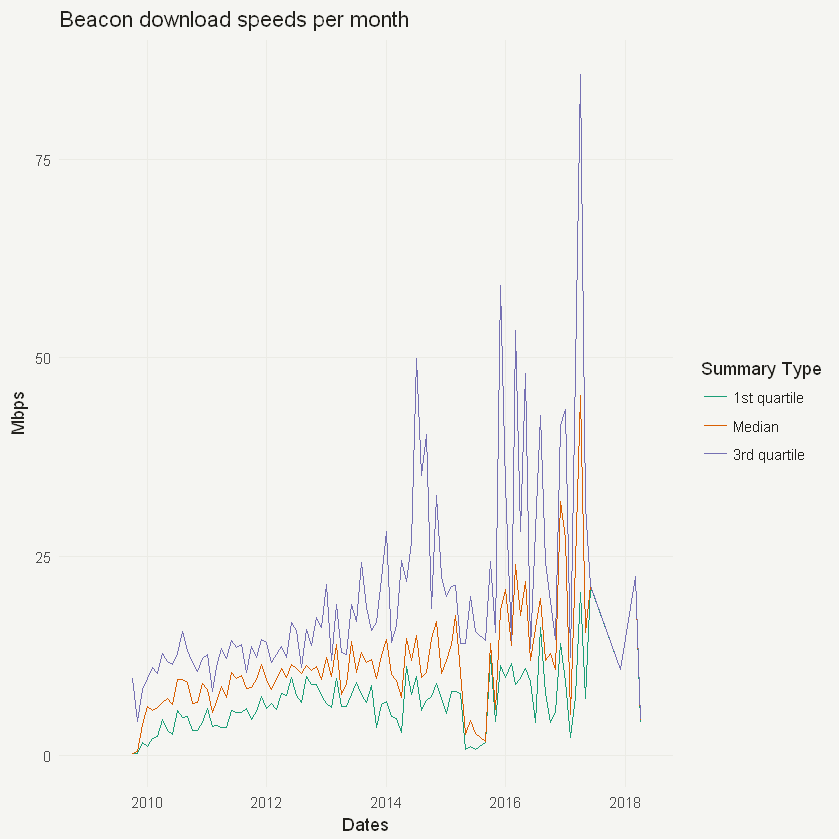

In [21]:
options(warn=-1)
first_cut="2009-09-01"
cutoff_date="2018-05-01"
net_nums<-todo_copies%>%data.frame%>%mutate("net_ip"=select_ip_net(ip))
keep_ip<-find_beacon(net_nums$day, net_nums$net_ip, 3) ###5 is the threshold here. 
keep_ip<-as.character(keep_ip$y)
beac_D<-todo_copies%>%data.frame%>%mutate("net_ip"=select_ip_net(ip))%>%filter(net_ip%in%keep_ip)
beac_D$day<-ymd(beac_D$day)
iqr_plot(beac_D, first_cut , "Beacon download speeds per month")+xlim(ymd("2009-01-01"),ymd(cutoff_date))
options(warn=0)

This chart is potentially interesting in and of itself. It tells the story of an internet that from 2009 until mid 2013 gets better for the whole country. In late 2013, high internet speeds continue to improve, while lower internet speeds plateau and start to fall off. In 2014, internet speeds improve dramatically for everyone, though much more so for those with good connections. Then things get weird. The month-to-month variance increases until 2017, when the variance goes to 0. 

It's the last change that's especially interesting, and that potentially explains a lot of the weirdness post 2014. We can zoom in around 2017 to see if there's any other useful information there.

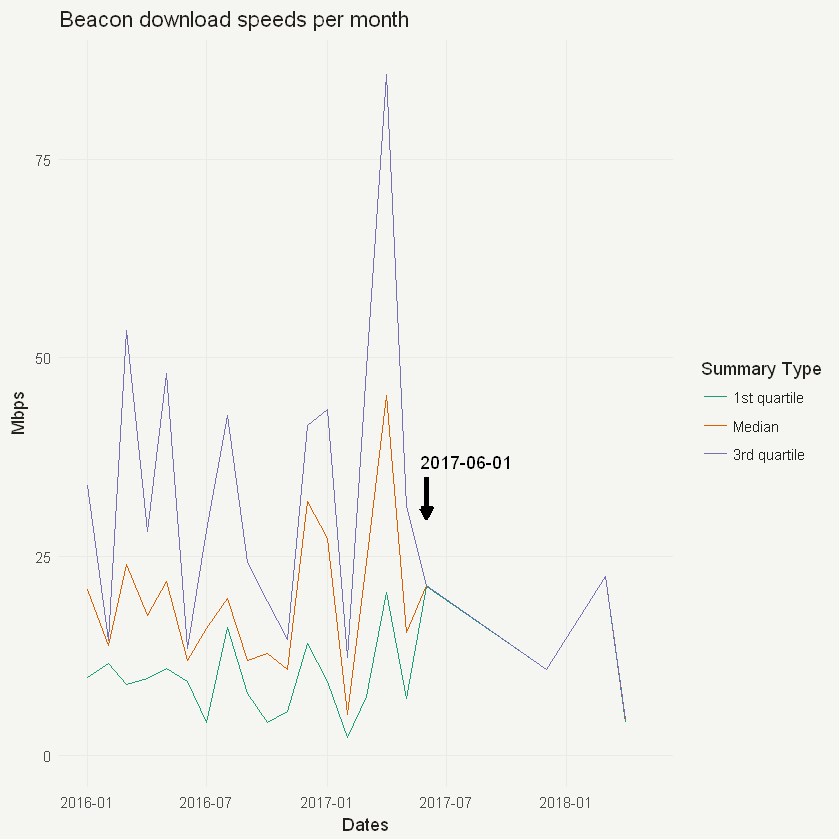

In [22]:
options(warn=-1)
iqr_plot(beac_D, first_cut , "Beacon download speeds per month")+xlim(ymd("2016-01-01"),ymd(cutoff_date))+
  geom_segment(arrow= arrow(type="closed", ends="first",length=unit(.2, "cm")),
               aes(x=ymd("2017-06-01"), xend=ymd("2017-06-01"), y=30, yend=35), size=1.5, color = "black")+
  annotate("text",label="2017-06-01",x=ymd("2017-08-01"), y = 37)
options(warn=0)

Zooming in, though there are month-to-month changes in internet speed of 25-50 Mbps, make this time period more legible, and emphasizes the date (June 2017) when the quantiles collapse. This means either  all the beacons have extremely similar test results or the number of beacons has basically gone to zero. To check this, I plotted the number of beacons testing per month.

### Happens because the number of beacons falls to basically 0

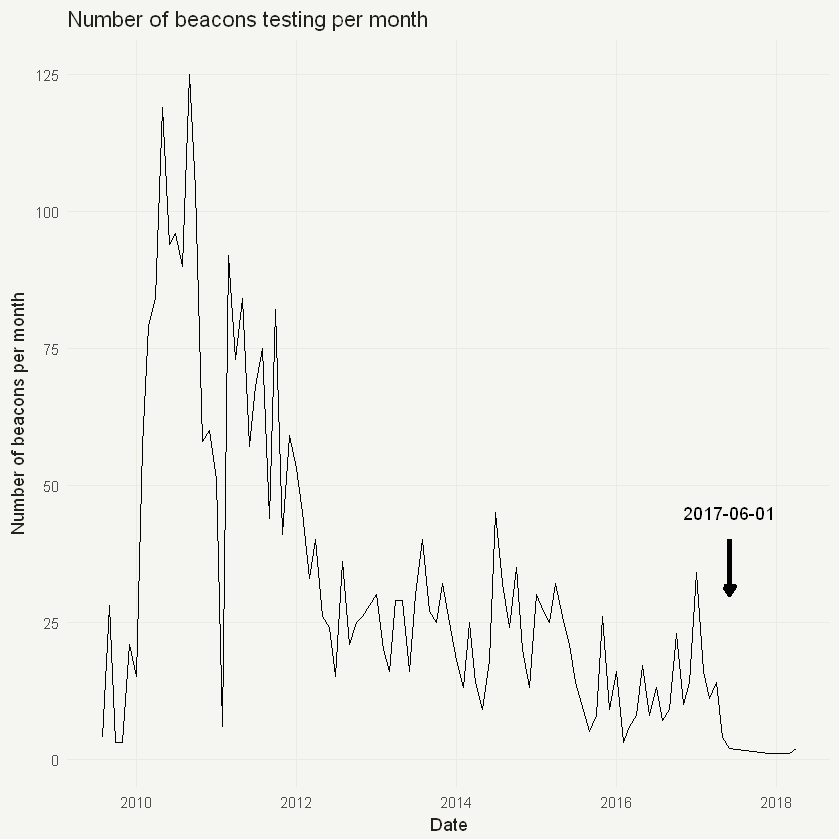

In [13]:
options(warn=-1)
beac_D%>%group_by(day)%>%summarise("num"=n())%>%ggplot(aes(x=day, y=num))+geom_line()+theme_scatter()+
  labs(x="Date", y="Number of beacons per month", title="Number of beacons testing per month")+
  geom_segment(arrow= arrow(type="closed", ends="first",length=unit(.2, "cm")),
               aes(x=ymd("2017-06-01"), xend=ymd("2017-06-01"), y=30, yend=40), size=1.5)+
  annotate("text",label="2017-06-01",x=ymd("2017-06-01"), y = 45)
options(warn=0)

This "explains" the previous graphs. The quantiles collapse in June 2017 because the number of beacons testing is in the low single digits starting in June. This also "explains" the increasing variance in the quantiles of the first plot. With fewer beacons, the estimates are going to be less smooth. 

It doesn't really explain what happened though. I still have two sets of questions. 

First, where did the "beacons" go? Why aren't they testing? What does that say about the quality of the internet in Puerto Rico? The way I'm measuring beacons definitely plays a role here (A network that joined one year ago can't be beacon when I require them to appear in >1 distinct years), but I don't think that makes this question uninteresting. Even if the old beacons were replaced by new networks that will be considered beacons under this definition once they've been around long enough, that turnover might be interesting. Did that turnover interact with hurricane damage in any way? (i.e was PR better prepared to handle weather damage because of the turnover, or did the change compound an already bad situation). I was wondering if anyone had an explanation or knew what might be happening with the beacons. 

I'm also curious about the lag time between when the beacons decreased and when the variance increased. The quantiles start getting wonky in 2014, but the number of beacons had been low for a year or two at that point. I don't know whether there's a sample size rule of thumb for good estimates of the median in the field, but I'm curious whether people think the increasing variability can be totally attributed to sampling issues or whether it represents something about the increasing inconsistency of internet speed on the island.
